# Settings

In [1]:
# Main switch
main_mode = 'vanilla' # one of 'vanilla', 'random', aware'

# Error bands
error_band_mode = 'none' # one of 'none', 'toy', ...

# Interpolation in final plot. If both are False, use a linear interpolator.
interpolate_gp = False
interpolate_cubic = False

# Which benchmark point to use
use_not_trained_benchmark = (main_mode != 'random')

# Preparations

In [2]:
import math
import copy
import itertools
import numpy as np

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern, RBF

In [3]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]

thetas_highlighted = []
if main_mode=='aware':
    thetas_highlighted = basis_thetas

print(thetas[theta1])
print(thetas[theta_benchmark])

[0.39293227 0.43229216]
[-0.5 -0.5]


In [4]:
def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

# Load results from cluster runs

In [5]:
# Which results to show
do_pbp_carl = True
do_pbp_carl_cal = True
do_carl = True
do_carl_cal = True
do_score = True
do_score_cal = True
do_combined = True
do_combined_cal = True
do_pbp_regression = True
do_regression = True
do_combinedregression = False

if main_mode == 'vanilla':
    common = ''
elif main_mode == 'random':
    common = '_random'
elif main_mode == 'aware':
    common = '_aware_basis'
else:
    raise ValueError
    
suffix_pbp_carl = common
suffix_pbp_carl_cal = '_calibrated' + common
suffix_carl = common
suffix_carl_cal = '_calibrated' + common
suffix_score = common
suffix_score_cal = '_calibrated' + common
suffix_combined = common
suffix_combined_cal = '_calibrated' + common
suffix_pbp_regression = common
suffix_regression = common
suffix_combinedregression = common

In [6]:
def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '.npy')


X_observed = np.load('../data/unweighted_events/X_test.npy')

llr_truth = _load('llr_truth', 'truth')
r_benchmark_truth = _load('r_' + benchmark_name + '_truth', 'truth')
p1_truth = _load('p1_test', '../data/unweighted_events/')
p_benchmark_truth = p1_truth * r_benchmark_truth
r_roam_truth = _load('r_roam_truth', 'truth')
scores_benchmark_truth = _load('scores_' + benchmark_name + '_truth', 'truth')
if error_band_mode == 'toy':
    pseudoexperiments_variance_truth = _load('pseudoexperiments_variance_truth', 'truth')
    
if do_pbp_carl:
    try:
        llr_pbp_carl = _load('llr_carl' + suffix_pbp_carl, 'point_by_point')
        r_benchmark_pbp_carl = _load('r_' + benchmark_name + '_carl' + suffix_pbp_carl, 'point_by_point')
    except IOError:
        do_pbp_carl = False

if do_pbp_carl_cal:
    try:
        llr_pbp_carl_cal = _load('llr_carl' + suffix_pbp_carl_cal, 'point_by_point')
        r_benchmark_pbp_carl_cal = _load('r_' + benchmark_name + '_carl' + suffix_pbp_carl_cal, 'point_by_point')
    except IOError:
        do_pbp_carl_cal = False
        
if do_carl:
    try:
        llr_carl = _load('llr_carl' + suffix_carl)
        r_benchmark_carl = _load('r_' + benchmark_name + '_carl' + suffix_carl)
        r_roam_carl = _load('r_roam_carl' + suffix_carl)
        scores_benchmark_carl = _load('scores_' + benchmark_name + '_carl' + suffix_carl)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_carl = _load('pseudoexperiments_variance_carl' + suffix_carl)
    except IOError:
        do_carl = False
    
if do_carl_cal:
    try:
        llr_carl_cal = _load('llr_carl' + suffix_carl_cal)
        r_benchmark_carl_cal = _load('r_' + benchmark_name + '_carl' + suffix_carl_cal)
        r_roam_carl_cal = _load('r_roam_carl' + suffix_carl_cal)
        scores_benchmark_carl_cal = _load('scores_' + benchmark_name + '_carl' + suffix_carl_cal)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_carl_cal = _load('pseudoexperiments_variance_carl' + suffix_carl_cal)
    except IOError:
        do_carl_cal = False
        
if do_score:
    try:
        llr_score = _load('llr_score' + suffix_score)
        r_benchmark_score = _load('r_' + benchmark_name + '_score' + suffix_score)
        r_roam_score = _load('r_roam_score' + suffix_score)
        scores_benchmark_score = _load('scores_' + benchmark_name + '_score' + suffix_score)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_score = _load('pseudoexperiments_variance_score' + suffix_score)
    except IOError:
        do_score = False
    
if do_score_cal:
    try:
        llr_score_cal = _load('llr_score' + suffix_score_cal)
        r_benchmark_score_cal = _load('r_' + benchmark_name + '_score' + suffix_score_cal)
        r_roam_score_cal = _load('r_roam_score' + suffix_score_cal)
        scores_benchmark_score_cal = _load('scores_' + benchmark_name + '_score' + suffix_score_cal)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_score_cal = _load('pseudoexperiments_variance_score' + suffix_score_cal)
    except IOError:
        do_score_cal = False
    
if do_combined:
    try:
        llr_combined = _load('llr_combined' + suffix_combined)
        r_benchmark_combined = _load('r_' + benchmark_name + '_combined' + suffix_combined)
        r_roam_combined = _load('r_roam_combined' + suffix_combined)
        scores_benchmark_combined = _load('scores_' + benchmark_name + '_combined' + suffix_combined)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_combined = _load('pseudoexperiments_variance_combined' + suffix_combined)
    except IOError:
        do_combined = False
    
if do_combined_cal:
    try:
        llr_combined_cal = _load('llr_combined' + suffix_combined_cal)
        r_benchmark_combined_cal = _load('r_' + benchmark_name + '_combined' + suffix_combined_cal)
        r_roam_combined_cal = _load('r_roam_combined' + suffix_combined_cal)
        scores_benchmark_combined_cal = _load('scores_' + benchmark_name + '_combined' + suffix_combined_cal)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_combined_cal = _load('pseudoexperiments_variance_combined' + suffix_combined_cal)
    except IOError:
        do_combined_cal = False
    
if do_pbp_regression:
    try:
        llr_pbp_regression = _load('llr_regression' + suffix_pbp_regression, 'point_by_point')
        r_benchmark_pbp_regression = _load('r_' + benchmark_name + '_regression' + suffix_pbp_regression, 'point_by_point')
    except IOError:
        do_pbp_regression = False
    
if do_regression:
    try:
        llr_regression = _load('llr_regression' + suffix_regression)
        r_benchmark_regression = _load('r_' + benchmark_name + '_regression' + suffix_regression)
        r_roam_regression = _load('r_roam_regression' + suffix_regression)
        scores_benchmark_regression = _load('scores_' + benchmark_name + '_regression' + suffix_regression)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_regression = _load('pseudoexperiments_variance_regression' + suffix_regression)
    except IOError:
        do_regression = False
    
if do_combinedregression:
    try:
        llr_combinedregression = _load('llr_combinedregression' + suffix_combinedregression)
        r_benchmark_combinedregression = _load('r_' + benchmark_name + '_combinedregression' + suffix_combinedregression)
        r_roam_combinedregression = _load('r_roam_combinedregression' + suffix_combinedregression)
        scores_benchmark_combinedregression = _load('scores_' + benchmark_name + '_combinedregression' + suffix_combinedregression)
        if error_band_mode == 'toy':
            pseudoexperiments_variance_combinedregression = _load('pseudoexperiments_variance_combinedregression'
                                                              + suffix_combinedregression)
    except IOError:
        do_combinedregression = False
    

# Uncertainty measures

In [7]:
n = np.array([10.,30.,100.,300.,1000.])

def calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance,
                                                   expected_llr,
                                                   lower_bound=0,
                                                   upper_bound=5):
    
    
    # Calculate noncentrality from expected LLR with all the data
    delta_llr_mean = 2. / 19.2 * (expected_llr - np.min(expected_llr)) # shape (n_thetas,)
    
    noncentralities = delta_llr_mean - 2. # shape (n_thetas,)
    print(noncentralities)
    
    def fit_function(n,a,b):
        return a/n + b

    #uncertainty = np.zeros(pseudoexperiments_variance.shape[0])
    #for i, var in enumerate(pseudoexperiments_variance):
    #    best_vals, covar = curve_fit(fit_function,
    #                                 n[lower_bound:upper_bound],
    #                                 var[lower_bound:upper_bound],
    #                                 p0=[var[2]*30.,0.])
    #    uncertainty[i] = (max(best_vals[1],0.))**0.5

In [8]:
#calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_carl, llr_carl)

In [9]:
def calculate_uncertainties_from_identity(llr):
    uncertainties = np.zeros_like(llr)
    uncertainties[:] = abs(llr[theta1])
    return uncertainties

In [10]:
if error_band_mode == 'toy':
    llr_uncertainties_truth = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_truth)
    if do_carl:
        llr_uncertainties_carl = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_carl)
    if do_carl_cal:
        llr_uncertainties_carl_cal = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_carl_cal)
    if do_score:
        llr_uncertainties_score = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_score)
    if do_score_cal:
        llr_uncertainties_score_cal = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_score_cal)
    if do_combined:
        llr_uncertainties_combined = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_combined)
    if do_combined_cal:
        llr_uncertainties_combined_cal = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_combined_cal)
    if do_regression:
        llr_uncertainties_regression = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_regression)
    if do_combinedregression:
        llr_uncertainties_combinedregression = calculate_uncertainties_from_pseudoexperiments(pseudoexperiments_variance_combinedregression)
elif error_band_mode == 'identity':
    llr_uncertainties_truth = calculate_uncertainties_from_identity(llr_truth)
    if do_carl:
        llr_uncertainties_carl = calculate_uncertainties_from_identity(llr_carl)
    if do_carl_cal:
        llr_uncertainties_carl_cal = calculate_uncertainties_from_identity(llr_carl_cal)
    if do_score:
        llr_uncertainties_score = calculate_uncertainties_from_identity(llr_score)
    if do_score_cal:
        llr_uncertainties_score_cal = calculate_uncertainties_from_identity(llr_score_cal)
    if do_combined:
        llr_uncertainties_combined = calculate_uncertainties_from_identity(llr_combined)
    if do_combined_cal:
        llr_uncertainties_combined_cal = calculate_uncertainties_from_identity(llr_combined_cal)
    if do_regression:
        llr_uncertainties_regression = calculate_uncertainties_from_identity(llr_regression)
    if do_combinedregression:
        llr_uncertainties_combinedregression = calculate_uncertainties_from_identity(llr_combinedregression)
elif error_band_mode == 'none':
    llr_uncertainties_truth = np.zeros_like(llr_truth)
    if do_carl:
        llr_uncertainties_carl = np.zeros_like(llr_carl)
    if do_carl_cal:
        llr_uncertainties_carl_cal = np.zeros_like(llr_carl_cal)
    if do_score:
        llr_uncertainties_score = np.zeros_like(llr_score)
    if do_score_cal:
        llr_uncertainties_score_cal = np.zeros_like(llr_score_cal)
    if do_combined:
        llr_uncertainties_combined = np.zeros_like(llr_combined)
    if do_combined_cal:
        llr_uncertainties_combined_cal = np.zeros_like(llr_combined_cal)
    if do_regression:
        llr_uncertainties_regression = np.zeros_like(llr_regression)
    if do_combinedregression:
        llr_uncertainties_combinedregression = np.zeros_like(llr_combinedregression)
    
else:
    raise ValueError
    
if do_pbp_carl:
    llr_uncertainties_pbp_carl = np.zeros_like(llr_pbp_carl)
if do_pbp_carl_cal:
    llr_uncertainties_pbp_carl_cal = np.zeros_like(llr_pbp_carl_cal)
if do_pbp_regression:
    llr_uncertainties_pbp_regression = np.zeros_like(llr_pbp_regression)
        

# Likelihood ratio histograms

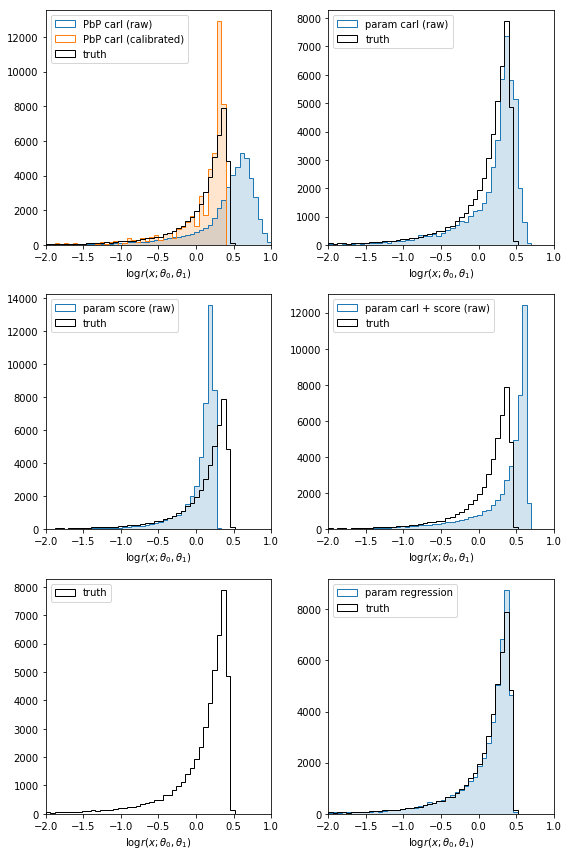

In [11]:
fig = plt.figure(figsize=(8.,12.))
this_range=(-2.,1.)
this_bins = 50



ax = plt.subplot(321)
if do_pbp_carl:
    plt.hist(np.log(r_benchmark_pbp_carl), range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_pbp_carl_cal:
    plt.hist(np.log(r_benchmark_pbp_carl_cal), range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_pbp_carl:
    plt.hist(np.log(r_benchmark_pbp_carl), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='PbP carl (raw)')
if do_pbp_carl_cal:
    plt.hist(np.log(r_benchmark_pbp_carl_cal), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='PbP carl (calibrated)')
plt.hist(np.log(r_benchmark_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(322)
if do_carl:
    plt.hist(np.log(r_benchmark_carl), range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_carl_cal:
    plt.hist(np.log(r_benchmark_carl_cal), range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_carl:
    plt.hist(np.log(r_benchmark_carl), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param carl (raw)')
if do_carl_cal:
    plt.hist(np.log(r_benchmark_carl_cal), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param carl (calibrated)')
plt.hist(np.log(r_benchmark_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(323)
if do_score:
    plt.hist(np.log(r_benchmark_score), range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_score_cal:
    plt.hist(np.log(r_benchmark_score_cal), range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_score:
    plt.hist(np.log(r_benchmark_score), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param score (raw)')
if do_score_cal:
    plt.hist(np.log(r_benchmark_score_cal), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param score (calibrated)')
plt.hist(np.log(r_benchmark_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(324)
if do_combined:
    plt.hist(np.log(r_benchmark_combined), range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_combined_cal:
    plt.hist(np.log(r_benchmark_combined_cal), range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_combined:
    plt.hist(np.log(r_benchmark_combined), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param carl + score (raw)')
if do_combined_cal:
    plt.hist(np.log(r_benchmark_combined_cal), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param carl + score (calibrated)')
plt.hist(np.log(r_benchmark_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(325)
if do_pbp_regression:
    plt.hist(np.log(r_benchmark_pbp_regression), range=this_range, bins=this_bins, color='C0', alpha=0.2)
    plt.hist(np.log(r_benchmark_pbp_regression), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='PbP regression')
plt.hist(np.log(r_benchmark_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])





ax = plt.subplot(326)
if do_regression:
    plt.hist(np.log(r_benchmark_regression), range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_combinedregression:
    plt.hist(np.log(r_benchmark_combinedregression), range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_regression:
    plt.hist(np.log(r_benchmark_regression), range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param regression')
if do_combinedregression:
    plt.hist(np.log(r_benchmark_combinedregression), range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param regression + score')
plt.hist(np.log(r_benchmark_truth), range=this_range, bins=this_bins, color='black', histtype='step',
         label='truth')
plt.legend(loc='upper left')
plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



plt.tight_layout()
plt.savefig("../figures/results/r_histograms_" + main_mode + ".pdf")

# Benchmark theta: approximate vs exact r(x)

No handles with labels found to put in legend.


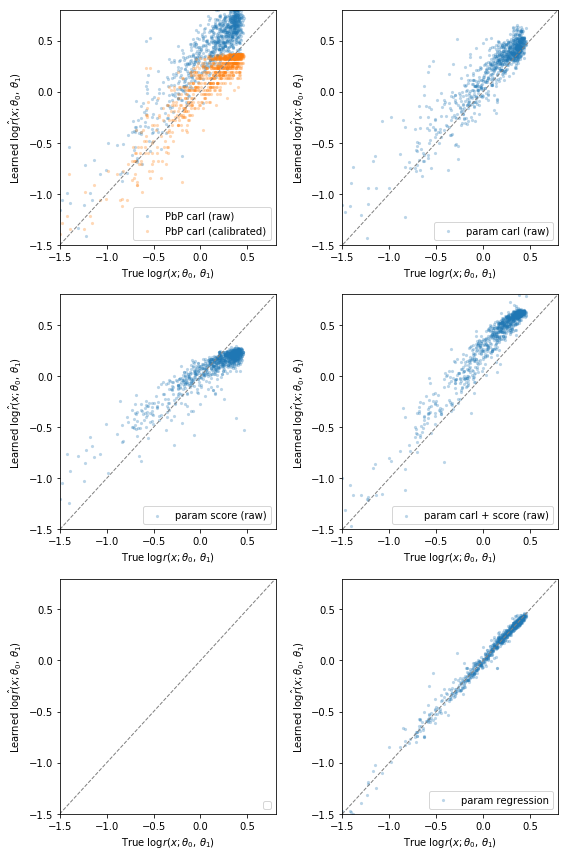

In [12]:
fig = plt.figure(figsize=(8.,12.))
xmin = -1.5
xmax = 0.8



ax = plt.subplot(321)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_pbp_carl:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_pbp_carl[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='PbP carl (raw)')
if do_pbp_carl_cal:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_pbp_carl_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='PbP carl (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(322)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_carl[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param carl (raw)')
if do_carl_cal:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_carl_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='param carl (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(323)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_score[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param score (raw)')
if do_score_cal:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_score_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='param score (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(324)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_combined:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_combined[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param carl + score (raw)')
if do_combined_cal:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_combined_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label=r'param carl + score (calibrated)')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(325)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_pbp_regression:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_pbp_regression[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='PbP regression')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



ax = plt.subplot(326)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_regression[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param regression')
if do_combinedregression:
    plt.scatter(np.log(r_benchmark_truth[::50]), np.log(r_benchmark_combinedregression[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='param regression + score')
plt.legend(loc='lower right')
plt.xlim(xmin,xmax)
plt.ylim(xmin,xmax)
plt.xlabel(r"True $\log r(x; \theta_0,\,\theta_1)$")
plt.ylabel(r"Learned $\log \hat{r}(x; \theta_0,\,\theta_1)$")



plt.tight_layout()
plt.savefig("../figures/results/r_scatter_" + main_mode + ".pdf")

# Benchmark thetas: histograms of errors on log r

No handles with labels found to put in legend.


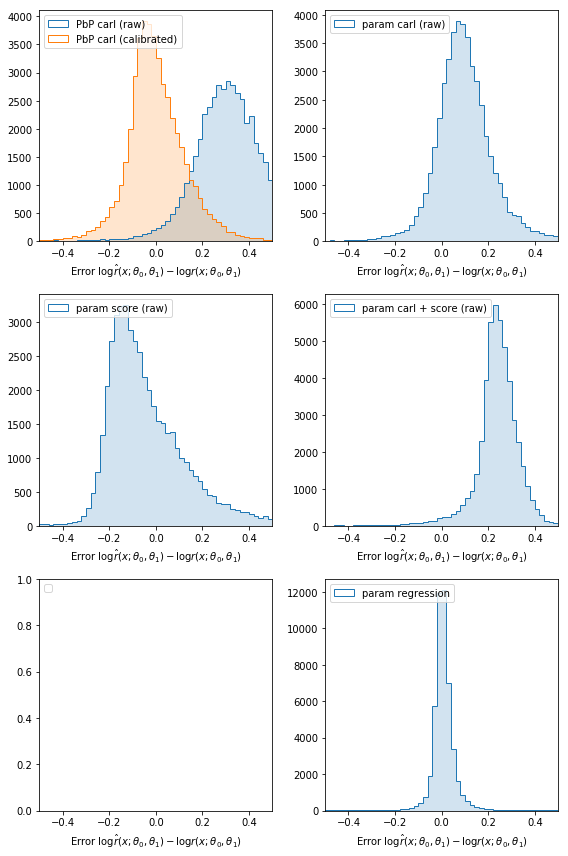

In [13]:
fig = plt.figure(figsize=(8.,12.))
this_range=(-.5,.5)
this_bins = 50



ax = plt.subplot(321)
if do_pbp_carl:
    plt.hist(np.log(r_benchmark_pbp_carl) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_pbp_carl_cal:
    plt.hist(np.log(r_benchmark_pbp_carl_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_pbp_carl:
    plt.hist(np.log(r_benchmark_pbp_carl) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', histtype='step',
             label='PbP carl (raw)')
if do_pbp_carl_cal:
    plt.hist(np.log(r_benchmark_pbp_carl_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', histtype='step',
             label='PbP carl (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'Error $\log \hat{r}(x; \theta_0, \theta_1) - \log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(322)
if do_carl:
    plt.hist(np.log(r_benchmark_carl) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_carl_cal:
    plt.hist(np.log(r_benchmark_carl_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_carl:
    plt.hist(np.log(r_benchmark_carl) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param carl (raw)')
if do_carl_cal:
    plt.hist(np.log(r_benchmark_carl_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param carl (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'Error $\log \hat{r}(x; \theta_0, \theta_1) - \log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(323)
if do_score:
    plt.hist(np.log(r_benchmark_score) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_score_cal:
    plt.hist(np.log(r_benchmark_score_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_score:
    plt.hist(np.log(r_benchmark_score) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param score (raw)')
if do_score_cal:
    plt.hist(np.log(r_benchmark_score_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param score (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'Error $\log \hat{r}(x; \theta_0, \theta_1) - \log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(324)
if do_combined:
    plt.hist(np.log(r_benchmark_combined) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_combined_cal:
    plt.hist(np.log(r_benchmark_combined_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_combined:
    plt.hist(np.log(r_benchmark_combined) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param carl + score (raw)')
if do_combined_cal:
    plt.hist(np.log(r_benchmark_combined_cal) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param carl + score (calibrated)')
plt.legend(loc='upper left')
plt.xlabel(r'Error $\log \hat{r}(x; \theta_0, \theta_1) - \log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



ax = plt.subplot(325)
if do_pbp_regression:
    plt.hist(np.log(r_benchmark_pbp_regression) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', alpha=0.2)
    plt.hist(np.log(r_benchmark_pbp_regression) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', histtype='step',
             label='PbP regression')
plt.legend(loc='upper left')
plt.xlabel(r'Error $\log \hat{r}(x; \theta_0, \theta_1) - \log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])





ax = plt.subplot(326)
if do_regression:
    plt.hist(np.log(r_benchmark_regression) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', alpha=0.2)
if do_combinedregression:
    plt.hist(np.log(r_benchmark_combinedregression) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', alpha=0.2)
if do_regression:
    plt.hist(np.log(r_benchmark_regression) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C0', histtype='step',
             label='param regression')
if do_combinedregression:
    plt.hist(np.log(r_benchmark_combinedregression) - np.log(r_benchmark_truth),
             range=this_range, bins=this_bins, color='C1', histtype='step',
             label='param regression + score')
plt.legend(loc='upper left')
plt.xlabel(r'Error $\log \hat{r}(x; \theta_0, \theta_1) - \log r(x; \theta_0, \theta_1)$')
plt.xlim(this_range[0],this_range[1])



plt.tight_layout()
plt.savefig("../figures/results/r_error_histograms_" + main_mode + ".pdf")

# Benchmark theta: error on log r vs max(p0, p1)

No handles with labels found to put in legend.
/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/axes/_base.py:2961: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=100.0, right=100.0
  'left=%s, right=%s') % (left, right))


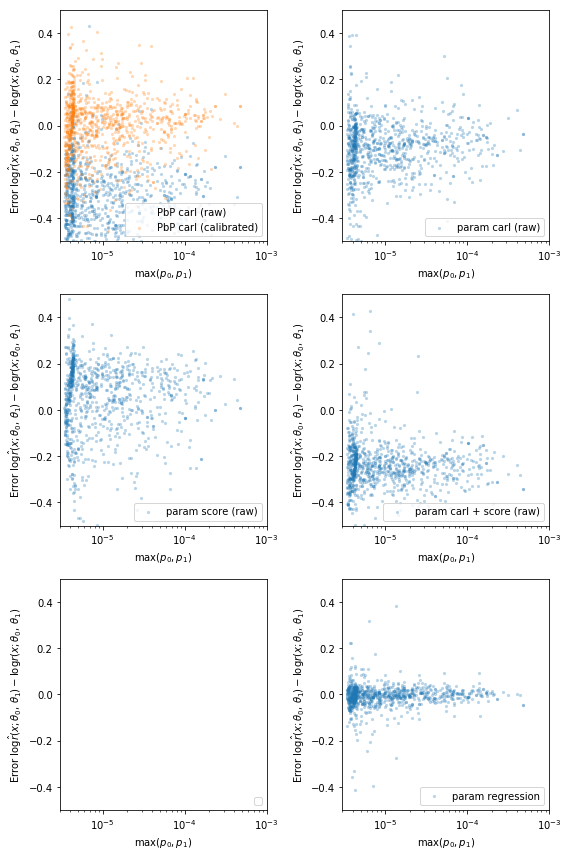

In [14]:
fig = plt.figure(figsize=(8.,12.))
xmin, xmax = -0.5, 0.5



ax = plt.subplot(321)
if do_pbp_carl:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_pbp_carl[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='PbP carl (raw)')
if do_pbp_carl_cal:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_pbp_carl_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='PbP carl (calibrated)')
plt.legend(loc='lower right')
ax.set_xscale("log", nonposx='clip')
plt.xlim(3.e-6,1.e-3)
plt.ylim(xmin,xmax)
plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")



ax = plt.subplot(322)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_carl[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param carl (raw)')
if do_carl_cal:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_carl_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='param carl (calibrated)')
plt.legend(loc='lower right')
ax.set_xscale("log", nonposx='clip')
plt.xlim(3.e-6,1.e-3)
plt.ylim(xmin,xmax)
plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")



ax = plt.subplot(323)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_score[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param score (raw)')
if do_score_cal:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_score_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='param score (calibrated)')
plt.legend(loc='lower right')
ax.set_xscale("log", nonposx='clip')
plt.xlim(3.e-6,1.e-3)
plt.ylim(xmin,xmax)
plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")



ax = plt.subplot(324)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_combined:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_combined[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param carl + score (raw)')
if do_combined_cal:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_combined_cal[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label=r'param carl + score (calibrated)')
plt.legend(loc='lower right')
ax.set_xscale("log", nonposx='clip')
plt.xlim(3.e-6,1.e-3)
plt.ylim(xmin,xmax)
plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")



ax = plt.subplot(325)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_pbp_regression:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_pbp_regression[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='PbP regression')
plt.legend(loc='lower right')
ax.set_xscale("log", nonposx='clip')
plt.xlim(3.e-6,1.e-3)
plt.ylim(xmin,xmax)
plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")



ax = plt.subplot(326)
plt.plot([-100.,100.],[-100.,100.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_regression[::50]),
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='param regression')
if do_combinedregression:
    plt.scatter(np.maximum(p_benchmark_truth, p1_truth)[::50], np.log(r_benchmark_truth[::50]) - np.log(r_benchmark_combinedregression[::50]),
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='param regression + score')
plt.legend(loc='lower right')
ax.set_xscale("log", nonposx='clip')
plt.xlim(3.e-6,1.e-3)
plt.ylim(xmin,xmax)
plt.ylabel(r"Error $\log \hat{r}(x; \theta_0,\,\theta_1) - \log r(x; \theta_0,\,\theta_1)$")
plt.xlabel(r"$\mathrm{max}(p_0, p_1)$")



plt.tight_layout()
plt.savefig("../figures/results/r_error_vs_pmax_" + main_mode + ".pdf")

# Exact vs approximate expected log likelihood ratios

No handles with labels found to put in legend.


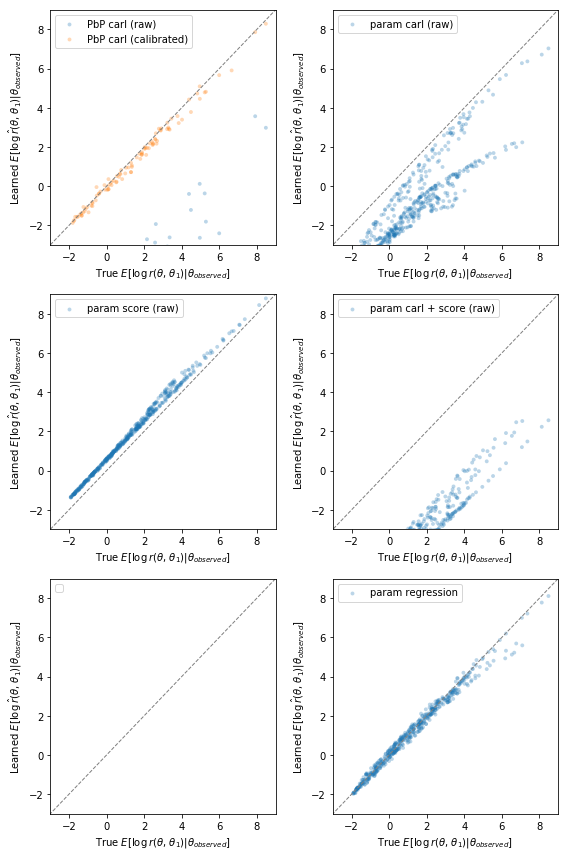

In [15]:
fig = plt.figure(figsize=(8.,12.))



ax = plt.subplot(321)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_pbp_carl:
    plt.scatter(llr_truth[pbp_training_thetas], llr_pbp_carl[pbp_training_thetas],
                marker='o', color='C0', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='PbP carl (raw)')
if do_pbp_carl_cal:
    plt.scatter(llr_truth[pbp_training_thetas], llr_pbp_carl_cal[pbp_training_thetas],
                marker='o', color='C1', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='PbP carl (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-3.,9.)
plt.ylim(-3.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(322)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(llr_truth[::2], llr_carl[::2],
                marker='o', color='C0', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param carl (raw)')
if do_carl_cal:
    plt.scatter(llr_truth[::2], llr_carl_cal[::2],
                marker='o', color='C1', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param carl (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-3.,9.)
plt.ylim(-3.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(323)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(llr_truth[::2], llr_score[::2], 
                marker='o', color='C0', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param score (raw)')
if do_score_cal:
    plt.scatter(llr_truth[::2], llr_score_cal[::2], 
                marker='o', color='C1', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param score (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-3.,9.)
plt.ylim(-3.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(324)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_combined:
    plt.scatter(llr_truth[::2], llr_combined[::2],
                marker='o', color='C0', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param carl + score (raw)')
if do_combined_cal:
    plt.scatter(llr_truth[::2], llr_combined_cal[::2],
                marker='o', color='C1', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param carl + score (calibrated)')
plt.legend(loc='upper left')
plt.xlim(-3.,9.)
plt.ylim(-3.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(325)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_pbp_regression:
    plt.scatter(llr_truth[pbp_training_thetas], llr_pbp_regression[pbp_training_thetas],
                marker='o', color='C0', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='PbP regression')
plt.legend(loc='upper left')
plt.xlim(-3.,9.)
plt.ylim(-3.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



ax = plt.subplot(326)
plt.plot([-10.,10.],[-10.,10.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(llr_truth[::2], llr_regression[::2],
                marker='o', color='C0',
                alpha=0.3,
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param regression')
if do_combinedregression:
    plt.scatter(llr_truth[::2], llr_combinedregression[::2],
                marker='o', color='C1', alpha=0.3, 
                s=[60. if t in thetas_highlighted else 15. for t in list(range(n_thetas))[::2]],
                lw=0.,
                label='param regression + score')
plt.legend(loc='upper left')
plt.xlim(-3.,9.)
plt.ylim(-3.,9.)
plt.xlabel(r"True $E[\log \, r(\theta,\,\theta_1)|\theta_{observed}]$")
plt.ylabel(r"Learned $E[\log \, \hat{r}(\theta,\,\theta_1)|\theta_{observed}]$")



plt.tight_layout()
plt.savefig("../figures/results/expected_likelihood_scatter_" + main_mode + ".pdf")

# Error on log r expectation over theta

In [16]:
llrs = []
labels = []
if do_pbp_carl:
    llrs.append(llr_pbp_carl)
    labels.append('PbP carl raw')
if do_pbp_carl_cal:
    llrs.append(llr_pbp_carl_cal)
    labels.append('PbP carl calibrated')
if do_carl:
    llrs.append(llr_carl)
    labels.append('param carl raw')
if do_carl_cal:
    llrs.append(llr_carl_cal)
    labels.append('param carl calibrated')
if do_score:
    llrs.append(llr_score)
    labels.append('param score raw')
if do_score_cal:
    llrs.append(llr_score_cal)
    labels.append('param score calibrated')
if do_combined:
    llrs.append(llr_combined)
    labels.append('param carl + score raw')
if do_combined_cal:
    llrs.append(llr_combined_cal)
    labels.append('param carl + score calibrated')
if do_pbp_regression:
    llrs.append(llr_pbp_regression)
    labels.append('PbP regression')
if do_regression:
    llrs.append(llr_regression)
    labels.append('param regression')
if do_combinedregression:
    llrs.append(llr_combinedregression)
    labels.append('param regression + score')
    
llr_errors = [llr - llr_truth for llr in llrs]

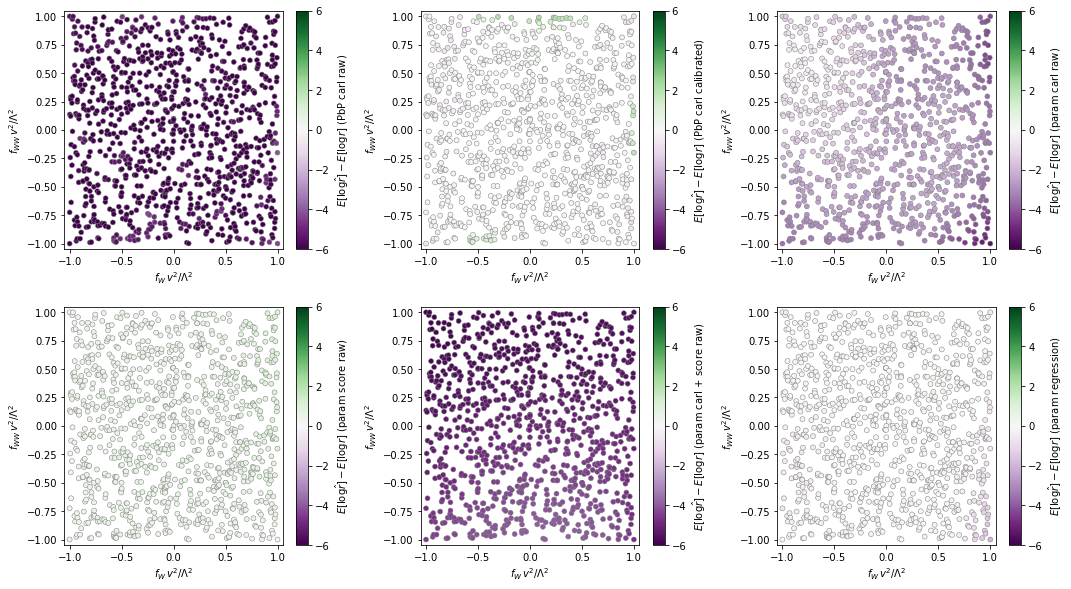

In [17]:
fig = plt.figure(figsize=(15.,16.))

for i, (label, err) in enumerate(zip(labels, llr_errors)):
    ax = plt.subplot(4, 3, i + 1)
    
    plt.scatter(thetas[::,0], thetas[::,1], c=err[::],
                s=25.,
                edgecolor='0.5', lw=0.5,
                cmap='PRGn',
                vmin=-6., vmax=6.)
    if len(thetas_highlighted) > 0:
        plt.scatter(thetas[thetas_highlighted,0], thetas[thetas_highlighted,1], c=err[thetas_highlighted],
                    s=150.,
                    edgecolor='0.5', lw=0.5,
                    cmap='PRGn',
                    vmin=-6., vmax=6.)
    cbar = plt.colorbar()
    
    plt.xlim(-1.05,1.05)
    plt.ylim(-1.05,1.05)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
    cbar.set_label(r'$E[\log \hat{r}] - E[\log r]$ (' + label + ')')
    
plt.tight_layout()
plt.savefig("../figures/results/expected_likelihood_errors_over_theta_" + main_mode + ".pdf")

# Benchmark thetas: exact vs approximate score (only raw parameterized)

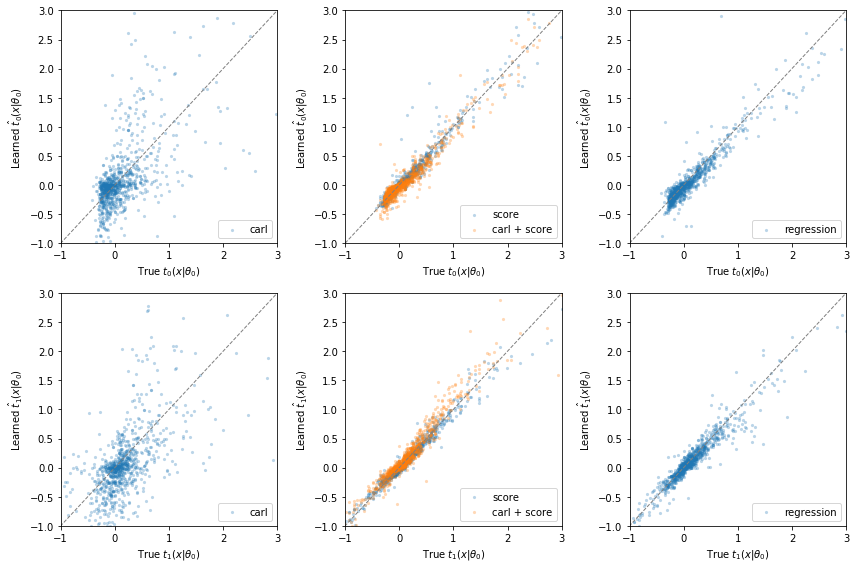

In [18]:
fig = plt.figure(figsize=(12.,8.))



ax = plt.subplot(231)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(scores_benchmark_truth[::50,0],scores_benchmark_carl[::50,0],
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='carl')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_0(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_0(x|\theta_0)$")



ax = plt.subplot(234)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_carl:
    plt.scatter(scores_benchmark_truth[::50,1],scores_benchmark_carl[::50,1],
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='carl')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_1(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_1(x|\theta_0)$")



ax = plt.subplot(232)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(scores_benchmark_truth[::50,0],scores_benchmark_score[::50,0],
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='score')
if do_combined:
    plt.scatter(scores_benchmark_truth[::50,0],scores_benchmark_combined[::50,0],
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='carl + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_0(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_0(x|\theta_0)$")



ax = plt.subplot(235)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_score:
    plt.scatter(scores_benchmark_truth[::50,1],scores_benchmark_score[::50,1],
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='score')
if do_combined:
    plt.scatter(scores_benchmark_truth[::50,1],scores_benchmark_combined[::50,1],
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='carl + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_1(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_1(x|\theta_0)$")



ax = plt.subplot(233)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(scores_benchmark_truth[::50,0],scores_benchmark_regression[::50,0],
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='regression')
if do_combinedregression:
    plt.scatter(scores_benchmark_truth[::50,0],scores_benchmark_combinedregression[::50,0],
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='regression + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_0(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_0(x|\theta_0)$")



ax = plt.subplot(236)
plt.plot([-5.,5.],[-5.,5.], ls='dashed', lw=1., c='0.5')
if do_regression:
    plt.scatter(scores_benchmark_truth[::50,1],scores_benchmark_regression[::50,1],
                marker='o', alpha=0.3, s=10., c='C0', lw=0.,
                label='regression')
if do_combinedregression:
    plt.scatter(scores_benchmark_truth[::50,1],scores_benchmark_combinedregression[::50,1],
                marker='o', alpha=0.3, s=10., c='C1', lw=0.,
                label='regression + score')
plt.legend(loc='lower right')
plt.xlim(-1.,3.)
plt.ylim(-1.,3.)
plt.xlabel(r"True $t_1(x|\theta_0)$")
plt.ylabel(r"Learned $\hat{t}_1(x|\theta_0)$")



plt.tight_layout()
plt.savefig("../figures/results/score_scatter_" + main_mode + ".pdf")

# Theta dependence (only param.)

In [19]:
ratios = [r_roam_truth]
labels = ['truth']
filenames = ['truth']
if do_carl:
    ratios.append(r_roam_carl)
    labels.append('param carl raw')
    filenames.append('carl')
if do_carl_cal:
    ratios.append(r_roam_carl_cal)
    labels.append('param carl calibrated')
    filenames.append('carl_calibrated')
if do_combined:
    ratios.append(r_roam_combined)
    labels.append('param carl + score raw')
    filenames.append('combined')
if do_combined_cal:
    ratios.append(r_roam_carl_cal)
    labels.append('param carl + score calibrated')
    filenames.append('combined_calibrated')
if do_regression:
    ratios.append(r_roam_regression)
    labels.append('param regression')
    filenames.append('regression')
if do_combinedregression:
    ratios.append(r_roam_combinedregression)
    labels.append('param regression + score')
    filenames.append('combinedregression')

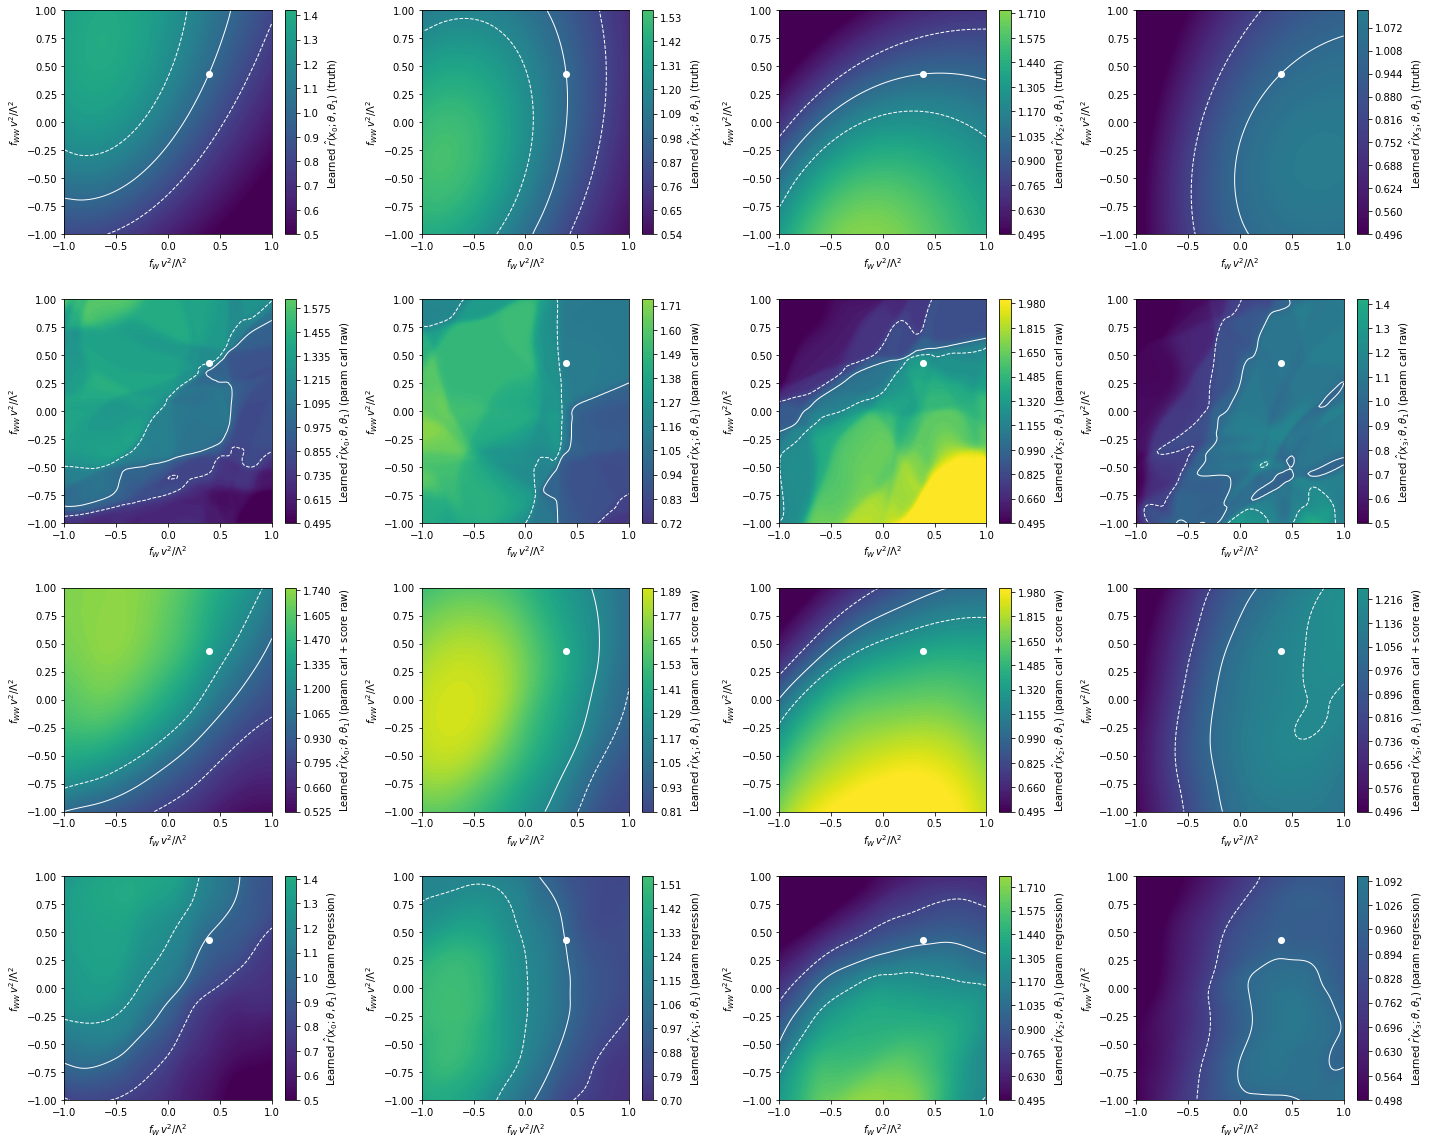

In [20]:
n_roaming = 10
show_roaming = [1,6,7,11]
rmin=0.5
rmax=2.0
n_roaming_show = len(show_roaming)

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

fig = plt.figure(figsize=(5.* n_roaming_show,4. * len(ratios)))

for i, (r, l) in enumerate(zip(ratios, labels)):
    for j in range(n_roaming_show):
        ax = plt.subplot(len(ratios), n_roaming_show,1 + n_roaming_show * i + j)

        cs = plt.contourf(xi, yi, np.clip(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)),rmin,rmax),
                          100, cmap="viridis", vmin=rmin, vmax=rmax)
        cbar = plt.colorbar()
        plt.contour(xi, yi, r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)), [0.8,1.,1.2],
                    linewidths=1., colors='white',
                    linestyles=['dashed','solid','dashed'])

        #plt.scatter(thetas[thetas_train,0], thetas[thetas_train,1],
        #            marker='o', c='w', alpha=0.5,  s=5., lw=0, zorder=8)
        plt.scatter([thetas[theta1, 0]], [thetas[theta1, 1]],
                    marker='o', c='w', s=50, lw=0, zorder=9)

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        cbar.set_label(r'Learned $\hat{r}(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')

plt.tight_layout()
plt.savefig("../figures/results/theta_dependence_comparison_" + main_mode + ".pdf")

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'lw'
  s)


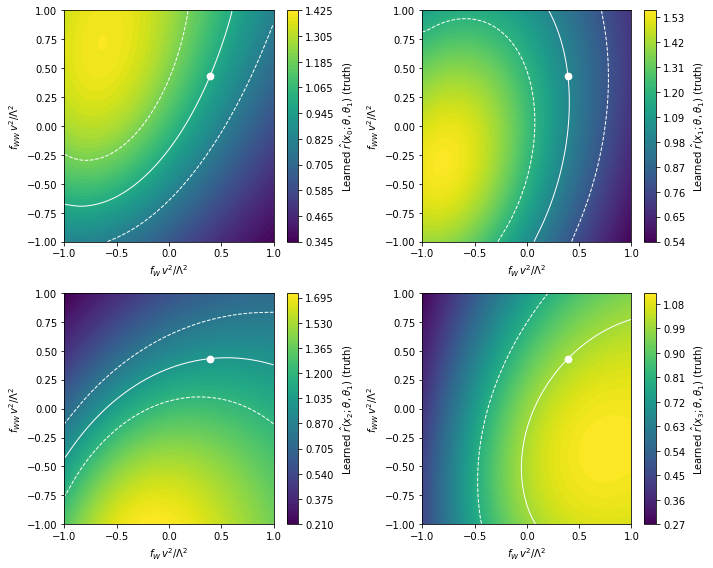

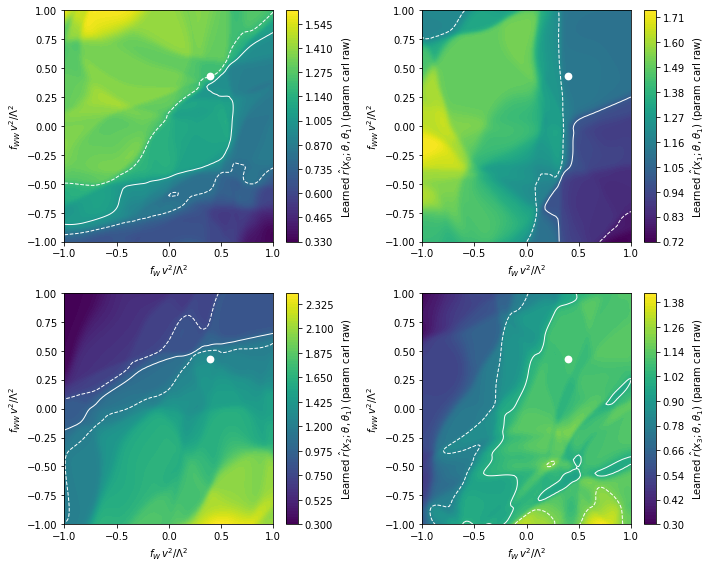

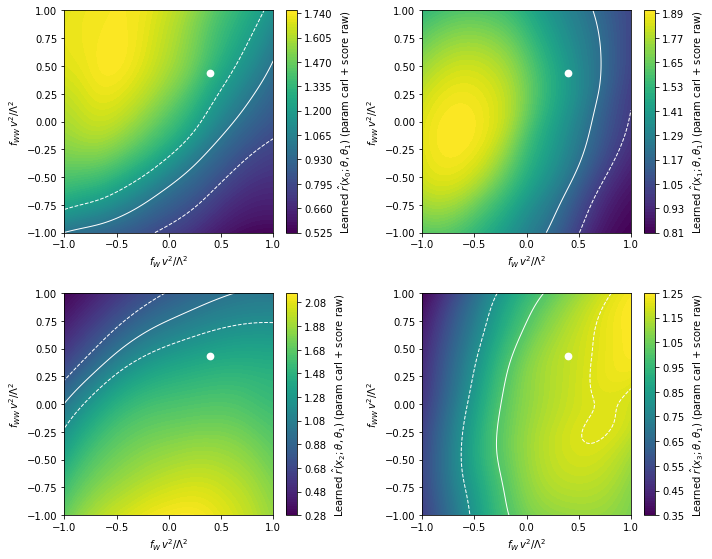

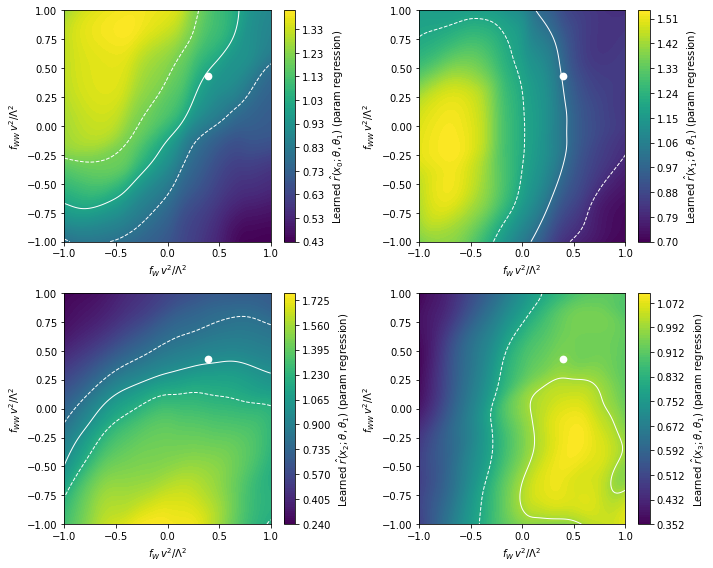

In [21]:
show_roaming = [1,6,7,11]#[9, 0, 1, 6]

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

for r, l, fn in zip(ratios, labels, filenames):
    fig = plt.figure(figsize=(10.,8.))
        
    for i in range(4):
        ax = plt.subplot(221 + i)

        cs = plt.contourf(xi, yi, r[show_roaming[i]].reshape((n_thetas_roam, n_thetas_roam)),
                          100, cmap="viridis",
                          lw=0.)
        cbar = plt.colorbar()
        plt.contour(xi, yi, r[show_roaming[i]].reshape((n_thetas_roam, n_thetas_roam)), [0.8,1.,1.2],
                    linewidths=1., colors='white',
                    linestyles=['dashed','solid','dashed'])

        if len(thetas_highlighted) > 0:
            plt.scatter(thetas[thetas_highlighted,0], thetas[thetas_highlighted,1],
                        marker='o', c='w', alpha=0.5,  s=15., lw=0, zorder=8)
        plt.scatter([thetas[theta1, 0]], [thetas[theta1, 1]],
                    marker='o', c='w', s=60, lw=0, zorder=9)

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        cbar.set_label(r'Learned $\hat{r}(x_' + str(i) + r'; \theta, \theta_1)$ (' + l + ')')

    plt.tight_layout()
    plt.savefig("../figures/results/theta_dependence_" + fn + "_" + main_mode + ".pdf")

# Benchmark theta: x dependence

In [22]:
ratios = [r_benchmark_truth]
labels = ['truth']
if do_pbp_carl:
    ratios.append(r_benchmark_pbp_carl)
    labels.append('PbP carl raw')
if do_pbp_carl_cal:
    ratios.append(r_benchmark_pbp_carl_cal)
    labels.append('PbP carl calibrated')
if do_carl:
    ratios.append(r_benchmark_carl)
    labels.append('param carl raw')
if do_carl_cal:
    ratios.append(r_benchmark_carl_cal)
    labels.append('param carl calibrated')
if do_combined:
    ratios.append(r_benchmark_combined)
    labels.append('param carl + score raw')
if do_combined_cal:
    ratios.append(r_benchmark_carl_cal)
    labels.append('param carl + score calibrated')
if do_pbp_regression:
    ratios.append(r_benchmark_pbp_regression)
    labels.append('PbP regression')
if do_regression:
    ratios.append(r_benchmark_regression)
    labels.append('param regression')
if do_combinedregression:
    ratios.append(r_benchmark_combinedregression)
    labels.append('param regression + score')

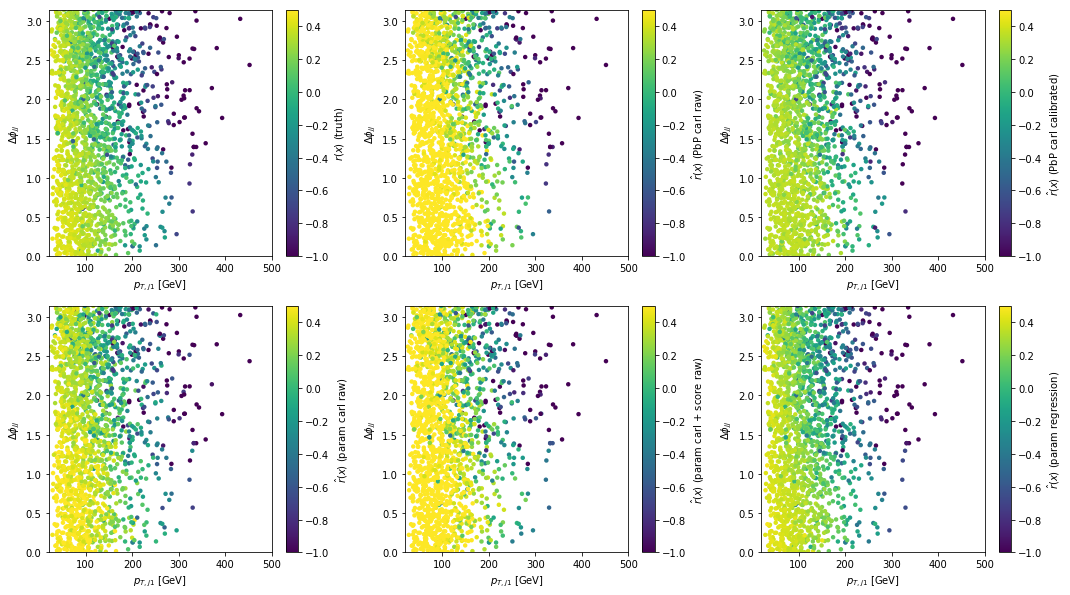

In [23]:
fig = plt.figure(figsize=(15.,12.))

for i, (d, l) in enumerate(zip(ratios, labels)):
    ax = plt.subplot(3, 3, i + 1)

    plt.scatter(X_observed[::25,1],
                X_observed[::25,41],
                c=np.log(d[::25]),
                vmin=-1., vmax=0.5,
                marker='o', s=20., lw=0.)
    cbar = plt.colorbar()
    
    plt.xlim(20.,500.)
    plt.ylim(0.,math.pi)
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    if i == 0:
        cbar.set_label(r'$r(x)$ (' + l + ')')
    else:
        cbar.set_label(r'$\hat{r}(x)$ (' + l + ')')

plt.tight_layout()
plt.savefig('../figures/results/x_dependence_' + main_mode + '.pdf')

# Likelihood over theta

In [24]:
def interpolate(thetas, z_thetas,
                xx, yy,
                xi=None, yi=None,
                use_gp=interpolate_gp,
                use_cubic=interpolate_cubic):
    
    if use_cubic:
        interpolator = CloughTocher2DInterpolator(thetas[:], z_thetas)
        zz = interpolator(np.dstack((xx.flatten(), yy.flatten())))
        zi = zz.reshape(xx.shape)
        
    elif use_gp:
        gp = GaussianProcessRegressor(normalize_y=True, 
                                      # kernel=C(1.0) * Matern(1.0,nu=0.5), n_restarts_optimizer=10)
                                      kernel=C(1.0, (1.e-9, 1.e9)) + C(1.0, (1.e-9, 1.e9)) * Matern(1.0,nu=0.5),
                                      n_restarts_optimizer=10, alpha=1.e-3)
        gp.fit(thetas[:], z_thetas[:])
        zz, _ = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
        zi = zz.reshape(xx.shape)
    else:
        interpolator = LinearNDInterpolator(thetas[:], z_thetas)
        zz = interpolator(np.dstack((xx.flatten(), yy.flatten())))
        zi = zz.reshape(xx.shape)
        
        #zi = griddata(thetas[:, 0], thetas[:, 1], z_thetas, xi, yi, interp='linear')
        
    mle = np.unravel_index(zi.argmin(),zi.shape)
    #zi -= zi[mle]
    zi *= 2.
    return zi, mle


def interpolate_with_uncertainties(thetas,
                                   z_thetas, delta_z_thetas,
                                   xx, yy, 
                                   xi=None, yi=None,
                                   use_gp=interpolate_gp):
    zi, mle = interpolate(thetas, z_thetas, xx, yy, xi, yi, use_gp)
    zi_diff = zi - zi[mle]
    zi_upper, _ = interpolate(thetas, z_thetas + delta_z_thetas, xx, yy, xi, yi, use_gp)
    zi_upper -= zi[mle]
    zi_lower, _ = interpolate(thetas, z_thetas - delta_z_thetas, xx, yy, xi, yi, use_gp)
    zi_lower -= zi[mle]
    return zi_diff, mle, zi_upper, zi_lower


# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 500)
yi = np.linspace(-1.0, 1.0, 500)
xx, yy = np.meshgrid(xi, yi)

# interpolate
zi_truth, mle_truth, zi_truth_upper, zi_truth_lower = interpolate_with_uncertainties(
                                                    thetas, llr_truth, llr_uncertainties_truth,
                                                        xx, yy, xi, yi)

if do_pbp_carl:
    zi_pbp_carl, mle_pbp_carl, zi_pbp_carl_upper, zi_pbp_carl_lower = \
                        interpolate_with_uncertainties(thetas[pbp_training_thetas],
                                                        llr_pbp_carl[pbp_training_thetas],
                                                        llr_uncertainties_pbp_carl[pbp_training_thetas],
                                                        xx, yy, xi, yi)

if do_pbp_carl_cal:
    zi_pbp_carl_cal, mle_pbp_carl_cal, zi_pbp_carl_cal_upper, zi_pbp_carl_cal_lower = \
                        interpolate_with_uncertainties(thetas[pbp_training_thetas],
                                                       llr_pbp_carl_cal[pbp_training_thetas],
                                                       llr_uncertainties_pbp_carl_cal[pbp_training_thetas],
                                                       xx, yy, xi, yi)
if do_carl:
    zi_carl, mle_carl, zi_carl_upper, zi_carl_lower = interpolate_with_uncertainties(thetas, llr_carl,
                                                                  llr_uncertainties_carl,
                                                                    xx, yy, xi, yi)
if do_carl_cal:
    zi_carl_cal, mle_carl_cal, zi_carl_cal_upper, zi_carl_cal_lower = interpolate_with_uncertainties(thetas, llr_carl_cal,
                                                                  llr_uncertainties_carl_cal,
                                                                    xx, yy, xi, yi)
if do_score:
    zi_score, mle_score, zi_score_upper, zi_score_lower = interpolate_with_uncertainties(thetas, llr_score,
                                                                  llr_uncertainties_score,
                                                                    xx, yy, xi, yi)
if do_score_cal:
    zi_score_cal, mle_score_cal, zi_score_cal_upper, zi_score_cal_lower = interpolate_with_uncertainties(thetas, llr_score_cal,
                                                                  llr_uncertainties_score_cal,
                                                                    xx, yy, xi, yi)
if do_combined:
    zi_combined, mle_combined, zi_combined_upper, zi_combined_lower = interpolate_with_uncertainties(
                                                    thetas, llr_combined, llr_uncertainties_combined,
                                                     xx, yy, xi, yi)
if do_combined_cal:
    zi_combined_cal, mle_combined_cal, zi_combined_cal_upper, zi_combined_cal_lower = interpolate_with_uncertainties(
                                                    thetas, llr_combined_cal, llr_uncertainties_combined_cal,
                                                     xx, yy, xi, yi)
if do_pbp_regression:
    zi_pbp_regression, mle_pbp_regression, zi_pbp_regression_upper, zi_pbp_regression_lower = interpolate_with_uncertainties(
                                                                   thetas[pbp_training_thetas], llr_pbp_regression[pbp_training_thetas],
                                                                  llr_uncertainties_pbp_regression[pbp_training_thetas],
                                                                    xx, yy, xi, yi)
if do_regression:
    zi_regression, mle_regression, zi_regression_upper, zi_regression_lower = interpolate_with_uncertainties(
                                                                   thetas, llr_regression,
                                                                  llr_uncertainties_regression,
                                                                    xx, yy, xi, yi)
if do_combinedregression:
    zi_combinedregression, mle_combinedregression, zi_combinedregression_upper, \
    zi_combinedregression_lower = interpolate_with_uncertainties(thetas, llr_combinedregression,
                                                         llr_uncertainties_combinedregression,
                                                         xx, yy, xi, yi)

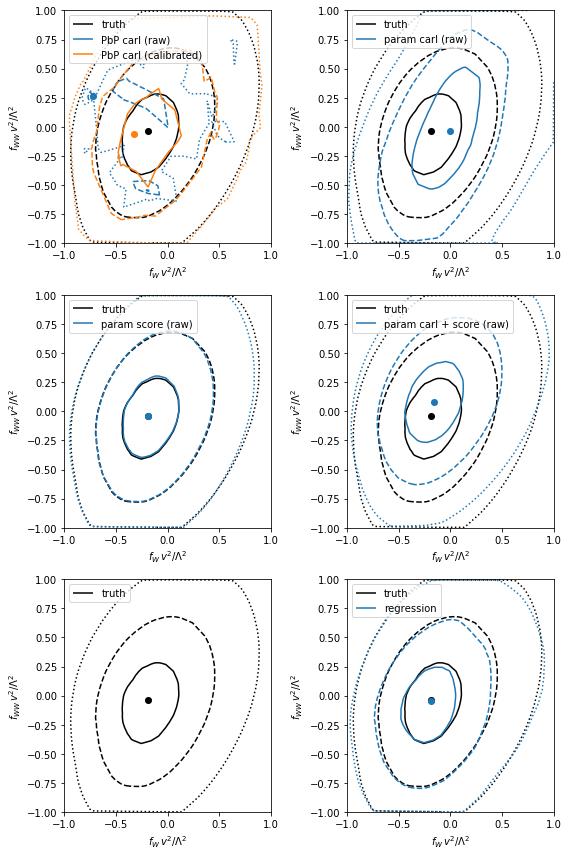

In [25]:
def plot_errorbands(xi, yi, zi_upper, zi_lower, color):
    for threshold in [1.,4.,9.]:
        band = (zi_upper > threshold) * (zi_lower < threshold) + (zi_upper < threshold) * (zi_lower > threshold)
        plt.contourf(xi, yi, band, [0.5,2.5], colors=color, alpha=0.15)
        
        

xi = np.linspace(-1.0, 1.0, 500)
yi = np.linspace(-1.0, 1.0, 500)
xx, yy = np.meshgrid(xi, yi)

fig = plt.figure(figsize=(8.,12.))



plt.subplot(321)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_pbp_carl:
    plot_errorbands(xi, yi, zi_pbp_carl_upper, zi_pbp_carl_lower, 'C0')
if do_pbp_carl_cal:
    plot_errorbands(xi, yi, zi_pbp_carl_cal_upper, zi_pbp_carl_cal_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_pbp_carl:
    cs = plt.contour(xi, yi, zi_pbp_carl, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('PbP carl (raw)')
if do_pbp_carl_cal:
    cs = plt.contour(xi, yi, zi_pbp_carl_cal, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('PbP carl (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_pbp_carl:
    plt.scatter([xi[mle_pbp_carl[1]]], [yi[mle_pbp_carl[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_pbp_carl_cal:
    plt.scatter([xi[mle_pbp_carl_cal[1]]], [yi[mle_pbp_carl_cal[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
#cbar.set_label(r'$-2 \, E[\Delta \, \log \, {L}]$ (truth)')



plt.subplot(322)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_carl:
    plot_errorbands(xi, yi, zi_carl_upper, zi_carl_lower, 'C0')
if do_carl_cal:
    plot_errorbands(xi, yi, zi_carl_cal_upper, zi_carl_cal_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_carl:
    cs = plt.contour(xi, yi, zi_carl, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('param carl (raw)')
if do_carl_cal:
    cs = plt.contour(xi, yi, zi_carl_cal, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('param carl (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_carl:
    plt.scatter([xi[mle_carl[1]]], [yi[mle_carl[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_carl_cal:
    plt.scatter([xi[mle_carl_cal[1]]], [yi[mle_carl_cal[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")



plt.subplot(323)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_score:
    plot_errorbands(xi, yi, zi_score_upper, zi_score_lower, 'C0')
if do_score_cal:
    plot_errorbands(xi, yi, zi_score_cal_upper, zi_score_cal_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_score:
    cs = plt.contour(xi, yi, zi_score, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('param score (raw)')
if do_score_cal:
    cs = plt.contour(xi, yi, zi_score_cal, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('param score (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_score:
    plt.scatter([xi[mle_score[1]]], [yi[mle_score[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_score_cal:
    plt.scatter([xi[mle_score_cal[1]]], [yi[mle_score_cal[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")



plt.subplot(324)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_combined:
    plot_errorbands(xi, yi, zi_combined_upper, zi_combined_lower, 'C0')
if do_combined_cal:
    plot_errorbands(xi, yi, zi_combined_cal_upper, zi_combined_cal_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black',
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_combined:
    cs = plt.contour(xi, yi, zi_combined, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('param carl + score (raw)')
if do_combined_cal:
    cs = plt.contour(xi, yi, zi_combined_cal, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('param carl + score (calibrated)')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_combined:
    plt.scatter([xi[mle_combined[1]]], [yi[mle_combined[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_combined_cal:
    plt.scatter([xi[mle_combined_cal[1]]], [yi[mle_combined_cal[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")



plt.subplot(325)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_regression:
    plot_errorbands(xi, yi, zi_regression_upper, zi_regression_lower, 'C0')
if do_combinedregression:
    plot_errorbands(xi, yi, zi_combinedregression_upper, zi_combinedregression_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black', 
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_pbp_regression:
    cs = plt.contour(xi, yi, zi_pbp_regression, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('PbP regression')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_pbp_regression:
    plt.scatter([xi[mle_pbp_regression[1]]], [yi[mle_pbp_regression[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")



plt.subplot(326)

plot_errorbands(xi, yi, zi_truth_upper, zi_truth_lower, 'black')
if do_regression:
    plot_errorbands(xi, yi, zi_regression_upper, zi_regression_lower, 'C0')
if do_combinedregression:
    plot_errorbands(xi, yi, zi_combinedregression_upper, zi_combinedregression_lower, 'C1')

cs = plt.contour(xi, yi, zi_truth, [1.,4.,9.],
                 linewidths=1.5, colors='black', 
                 linestyles=['solid','dashed','dotted'])
cs.collections[0].set_label('truth')
if do_regression:
    cs = plt.contour(xi, yi, zi_regression, [1.,4.,9.],
                     linewidths=1.5, colors='C0',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('regression')
if do_combinedregression:
    cs = plt.contour(xi, yi, zi_combinedregression, [1.,4.,9.],
                     linewidths=1.5, colors='C1',
                     linestyles=['solid','dashed','dotted'])
    cs.collections[0].set_label('regression + score')

plt.scatter([xi[mle_truth[1]]], [yi[mle_truth[0]]],
            marker='o', c='black', s=50, lw=0, zorder=10)
if do_regression:
    plt.scatter([xi[mle_regression[1]]], [yi[mle_regression[0]]],
                marker='o', c='C0', s=50, lw=0, zorder=10)
if do_combinedregression:
    plt.scatter([xi[mle_combinedregression[1]]], [yi[mle_combinedregression[0]]],
                marker='o', c='C1', s=50, lw=0, zorder=10)
    
plt.legend(loc='upper left')

plt.xlim(-1.0, 1.0)
plt.ylim(-1.0, 1.0)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")



plt.tight_layout()
plt.savefig("../figures/results/likelihood_contours_" + main_mode + ".pdf")

# Individual LLR outputs for debugging

ValueError: min() arg is an empty sequence

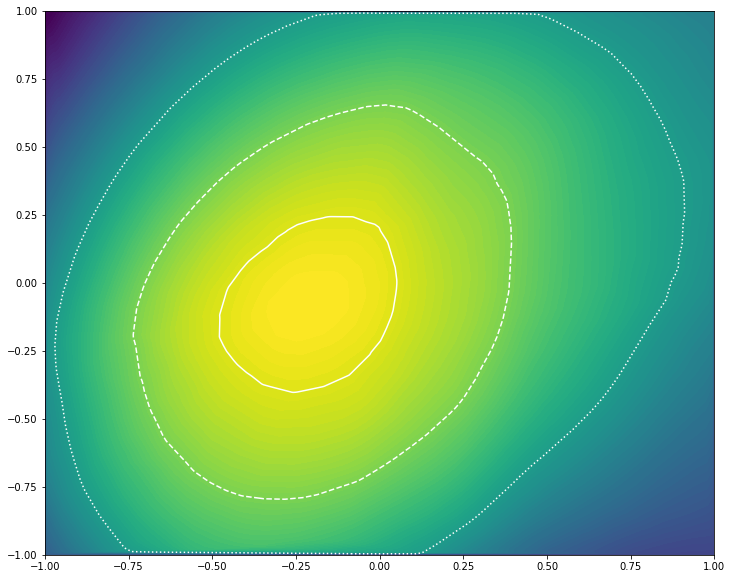

In [26]:
plt.figure(figsize=(12.,10.))

cs = plt.contourf(xi, yi, np.clip(zi_regression,0.,20.), 100, vmin=0.,vmax=20., cmap='viridis_r')
#plt.colorbar(cs)
cs = plt.contour(xi, yi, zi_regression, [1.,4.,9.],
                 linewidths=1.5, colors='w',
                 linestyles=['solid','dashed','dotted'])
plt.scatter(thetas[thetas_highlighted,0], thetas[thetas_highlighted,1],
            c=2. * llr_regression[thetas_highlighted] - min(2. * llr_regression[thetas_highlighted]),
            s=200., lw=1., cmap='viridis_r', edgecolors='k',
           vmin=0., vmax=20.)
cbar = plt.colorbar()
plt.xlim(-1.,1.)
plt.ylim(-1.,1.)

plt.show()